In [67]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import pandas as pd
from PIL import Image
from scipy import ndimage
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.io import imread_collection
from pathlib import Path
import itertools
import cv2
import math
%matplotlib inline

# Deep Drink
Using image inpainting to censor images of alcoholic beverages.

## Pre-processing: Loading Data

In [68]:
# Load images from the local images folder
# Images downloaded from Open Images using 
# https://github.com/EscVM/OIDv4_ToolKit
def load_images():
    img_dir = 'testimages/*.jpg'
    img_col = imread_collection(img_dir)
    final_col = []
    img_files = [x.replace("testimages/", "")[:-4] for x in img_col.files]
    for (img, fn) in zip(img_col, img_files):
        img = img/255.
        #img_resize = resize(img, output_shape=(num_px, num_px), mode='constant')
        final_col.append((fn, img))
    return final_col

In [69]:
# Load images into a collection
images = load_images()

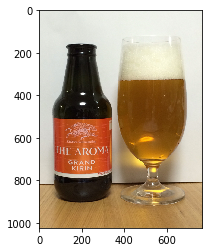

In [70]:
# Example of a picture
index = 1
plt.imshow(images[index][1])

## Custom Object Detection with YOLO
The following section was adapted from https://www.arunponnusamy.com/yolo-object-detection-opencv-python.html.


We collected "beer" images from Open Images (https://github.com/openimages/dataset) and WyattAutomation's open source project (https://github.com/WyattAutomation/Train-YOLOv3-with-OpenImagesV4). Revising this code allowed us to create a set of training images with labels. Altering the Darknet/YOLO project allowed us to custom train their model to detect a single class ("beer"). The weights for the model ended up plateauing around an average loss of ~0.5 (with learning rate .001, batches of 16). 

We tried adding more images to the training set to see if we could get our average loss closer to .06, however, it made our average loss metric worse. Attempting to play with learning rate and subdivision size also was fruitless. Perhaps if we had more time we could have figured something out, but with each iteration taking hours to train an average loss of 0.5 was the best we could get. 

In [71]:
# Adapted from https://www.arunponnusamy.com/yolo-object-detection-opencv-python.html

pretrained_weights = '/Users/kasey/Desktop/StanfordGSB/DeepDrink/FinalTraining/beer_10000.weights'
config_file = '/Users/kasey/Desktop/StanfordGSB/DeepDrink/beer.cfg'
classes_raw = '/Users/kasey/Desktop/StanfordGSB/DeepDrink/beer.txt'

# read class names from text file
classes = None
g = open(classes_raw, 'r')

with open(classes_raw, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# generate different colors for different classes 
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

# read pre-trained model and config file
net = cv2.dnn.readNet(pretrained_weights, config_file)


In [72]:
# function to get the output layer names 
# in the architecture
def get_output_layers(net):
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    return output_layers

# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = str(classes[class_id])
    color = COLORS[class_id]
    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)
    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 5)
    

In [73]:
# run inference through the network
# and gather predictions from output layers

class_ids = {}
confidences = {}
boxes = {}
conf_threshold = 0.5
nms_threshold = 0.4


def input_images():
    for name,_ in images:
        image = cv2.imread("testimages/"+str(name)+".jpg",3)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        Width = image.shape[1]
        Height = image.shape[0]
        scale = 0.005
        # create input blob 
        blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

        # set input blob for the network
        net.setInput(blob)

        outs = net.forward(get_output_layers(net))

        # initialization
        class_ids[name] = []
        confidences[name] =[]
        boxes[name] = []
        
        img_class_ids = []
        img_confidences = []
        img_boxes = []

        # for each detetion from each output layer 
        # get the confidence, class id, bounding box params
        # and ignore weak detections (confidence < 0.5)
        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:
                    center_x = int(detection[0] * Width)
                    center_y = int(detection[1] * Height)
                    w = int(detection[2] * Width)
                    h = int(detection[3] * Height)
                    x = center_x - w / 2
                    y = center_y - h / 2
                    img_class_ids.append(class_id)
                    img_confidences.append(float(confidence))
                    img_boxes.append([x, y, w, h])
                    
                    
        class_ids[name].append(img_class_ids)
        confidences[name].append(img_confidences)
        boxes[name].append(img_boxes)
        
    return class_ids, confidences, boxes

In [74]:
class_ids, confidences, boxes = input_images()

In [75]:
print(confidences)

{'0a585ca3a0abee5d': [[0.6124891638755798, 0.965808093547821]], '0a38941cedcf3e16': [[0.9003872275352478, 0.5439431667327881]], 'd32f37b94e40e78a': [[0.8237142562866211]], 'ee64c756a5309742': [[0.6983169317245483]], 'ffb7f844a65d80fe': [[]], 'kaseyandvalerie2': [[0.9123196005821228, 0.7076126337051392]], 'test4': [[0.8878860473632812]]}


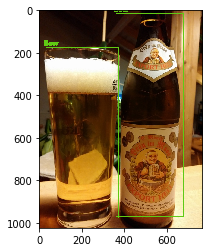

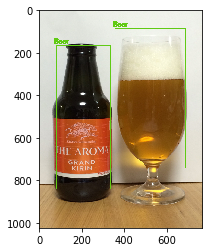

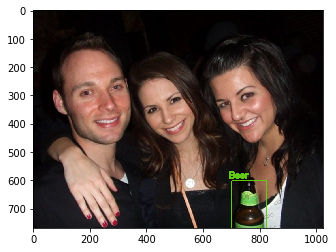

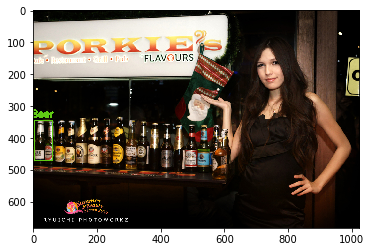

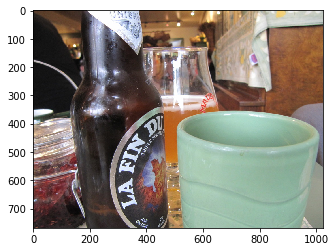

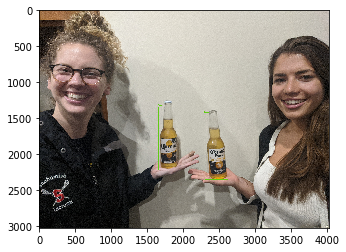

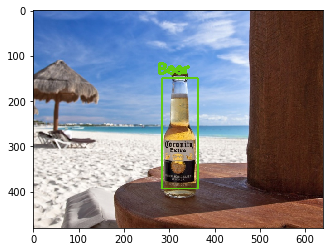

In [76]:
# apply non-max suppression

for j,k in enumerate(confidences.keys()):
    #print(k)
    #print(i)
    
    image = cv2.imread("testimages/"+str(k)+".jpg",3)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    indices = cv2.dnn.NMSBoxes(boxes[k][0], confidences[k][0], conf_threshold, nms_threshold)
    img_bb = image.copy()

    # go through the detections remaining
    # after nms and draw bounding box
    for i in indices:
        i = i[0]
        box = boxes[k][0][i]
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]

        draw_bounding_box(img_bb, class_ids[k][0][i], confidences[k][0][i], round(x), round(y), round(x+w), round(y+h))

    #  display output image  
    plt.imshow(img_bb)
    plt.show()



As stated earlier, our average loss ended up not going lower than 0.5 after 10,000+ iterations. Below is a graph showing the average loss each iteration and then a close up of the oscillation during the last 2500 iterations (iteration 2500-5000). 

Because our average loss is 10x what it should be, our bounding boxes aren't very accurate. Rarely is an entire beer bottle bounded which will cause issues when we try to inpaint. Also, it looks like the model is much better at bottle detection than glass detection (despite both types of images being in the training set). 

In [77]:
data = pd.read_csv("modeltraining.csv")
data.head()

batch   total_loss     avg_loss   learning_rate       time   images
0      1  1356.074829  1356.074829             0.0  12.144755       32
1      2  1359.673584  1356.434692             0.0  10.909788       64
2      3  1361.712158  1356.962402             0.0  10.996301       96
3      4  1361.170898  1357.383301             0.0  10.924717      128
4      5  1362.055176  1357.850464             0.0  11.062466      160

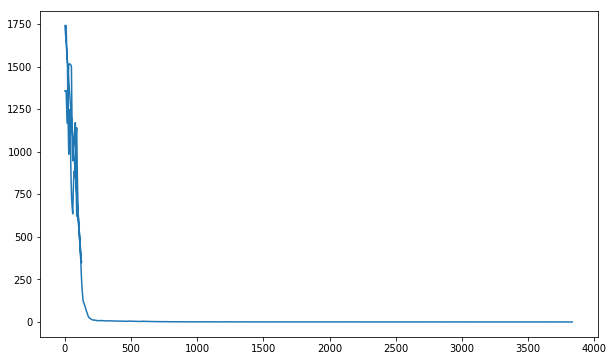

In [78]:
plt.figure(figsize=(10,6))
plt.plot(data["batch"], data[" avg_loss"])
plt.show()

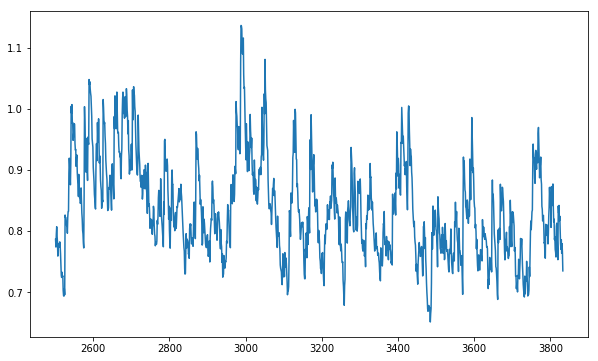

In [79]:
plt.figure(figsize=(10,6))
plt.plot(data[data.batch > 2500]["batch"], data[data.batch > 2500][" avg_loss"])
plt.show()

## Image Inpainting

### Drawing the image mask

In [80]:
def draw_mask(img, class_id, confidence, x, y, x_plus_w, y_plus_h): 
    label = str(classes[class_id])
    color = COLORS[class_id]
    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), [255, 255, 255], -1)
    
def blank_img(img):
    img2 = img.copy()
    height, width = img2.shape[:2]
    print(img2.shape)
    cv2.rectangle(img2, (0,0), (width, height), [0,0,0], -1)
    return img2


(1024, 768, 3)


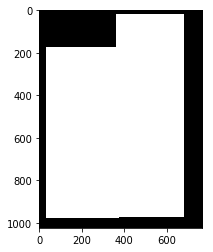

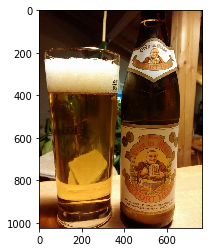

(1024, 768, 3)


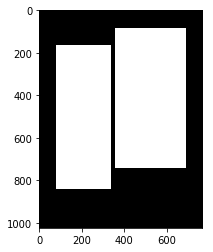

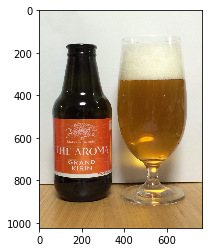

(768, 1024, 3)


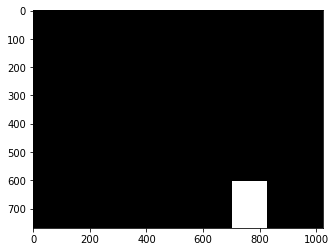

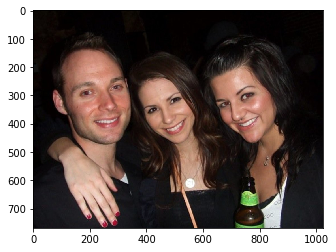

(683, 1024, 3)


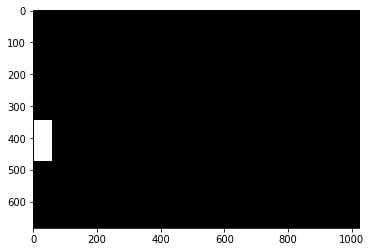

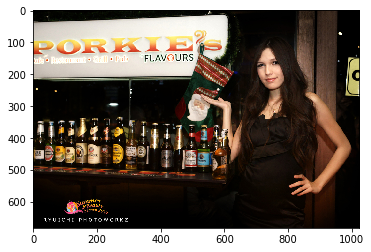

(768, 1024, 3)


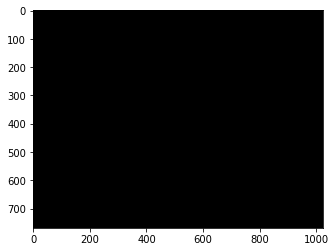

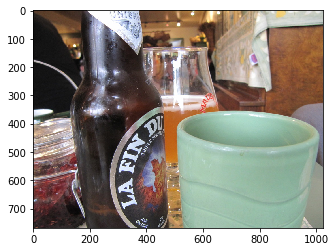

(3024, 4032, 3)


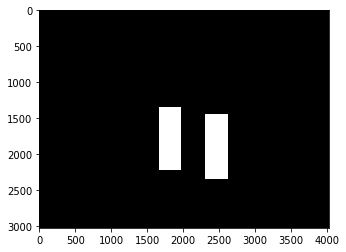

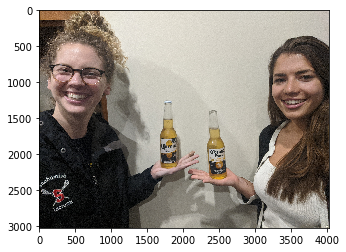

(480, 640, 3)


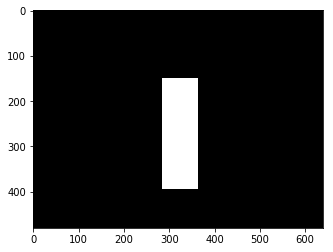

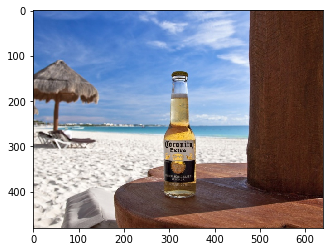

In [81]:
# go through the detections remaining
# after nms and draw mask
#img_gray = cv2.cvtColor(img_msk, cv2.COLOR_BGR2GRAY)
#(thresh, blackAndWhiteImage) = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)

for j,k in enumerate(confidences.keys()):
    #print(k)
    #print(i)
    
    image = cv2.imread("testimages/"+str(k)+".jpg",3)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_msk = image.copy()
    img_blank = blank_img(img_msk)
    indices = cv2.dnn.NMSBoxes(boxes[k][0], confidences[k][0], conf_threshold, nms_threshold)

    for i in indices:
        i = i[0]
        box = boxes[k][0][i]
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]
        draw_mask(img_blank, class_ids[k][0][i], confidences[k][0][i], round(x), round(y), round(x+w), round(y+h))

    #  display output image  
    plt.imshow(img_blank)
    plt.show()
    plt.imshow(image)
    plt.show()
    cv2.imwrite('beerMask'+str(k)+'.jpg', img_blank)


In [82]:
def inpaint_images():
    dst_list = []
    dst2_list = []
    for k in confidences.keys():
        image = cv2.imread("testimages/"+str(k)+".jpg",3)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread('beerMask'+str(k)+'.jpg', 0)
        dst = cv2.inpaint(image,mask,3,cv2.INPAINT_NS)
        dst2 = cv2.inpaint(image,mask,3, cv2.INPAINT_TELEA)
        dst_list.append((dst, image))
        dst2_list.append((dst2, image))
    return dst_list, dst2_list

### The Mask

In [83]:
ns_method, at_method = inpaint_images()

### The Navier-Stokes Method

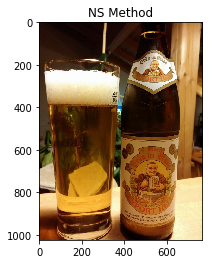

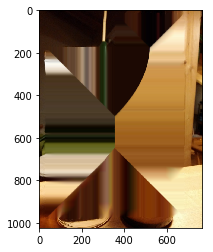

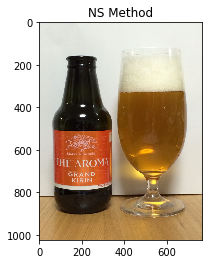

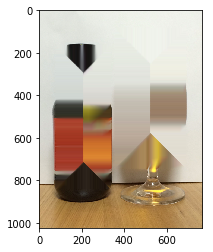

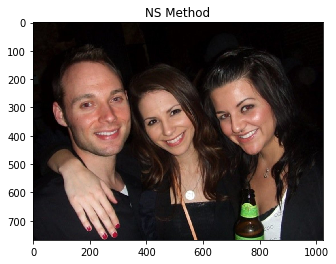

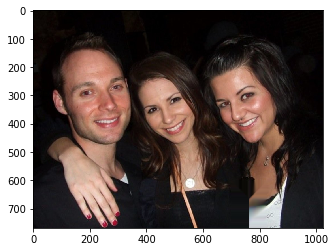

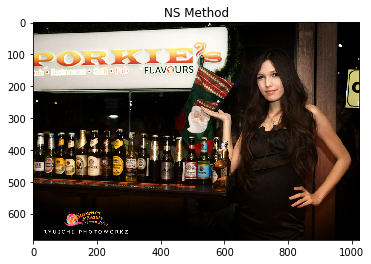

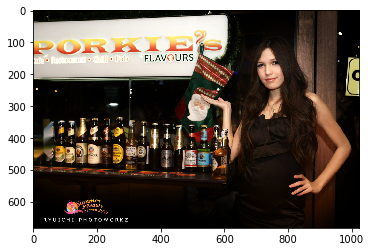

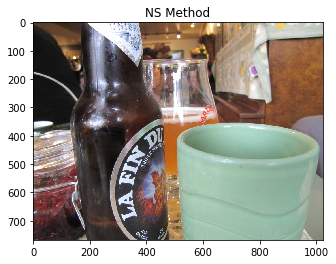

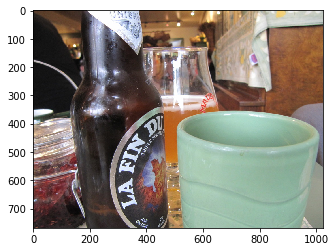

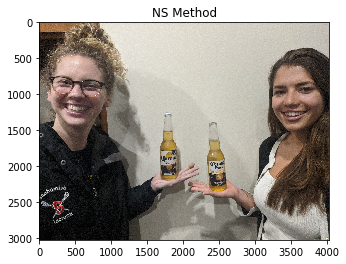

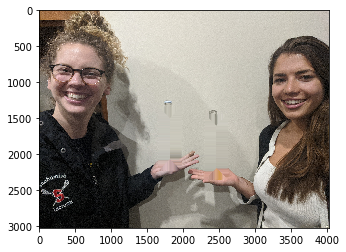

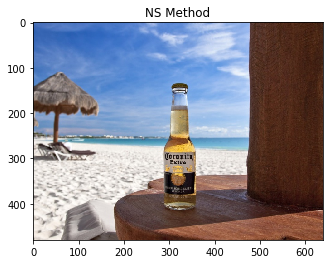

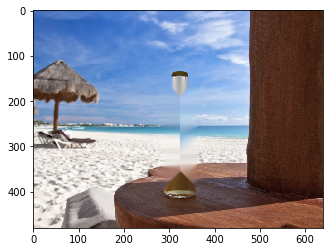

In [84]:
# NS METHOD
for (dst,img) in ns_method:
    plt.imshow(img)
    plt.title("NS Method")
    plt.show()
    plt.imshow(dst)
    plt.show()

### Method by Alexandru Telea

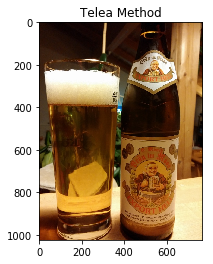

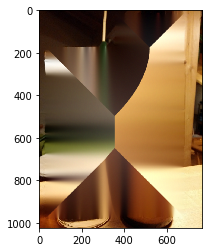

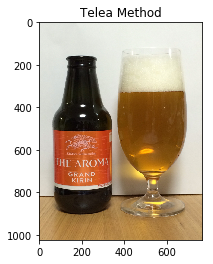

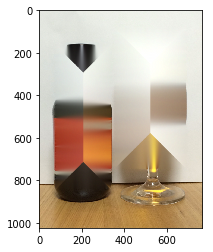

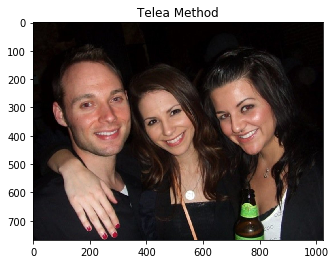

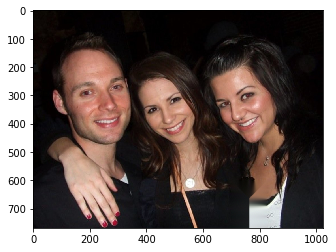

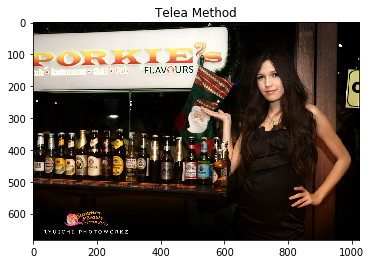

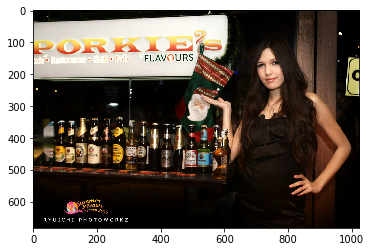

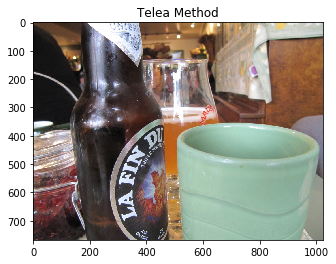

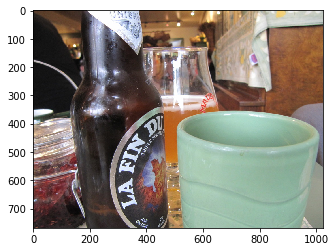

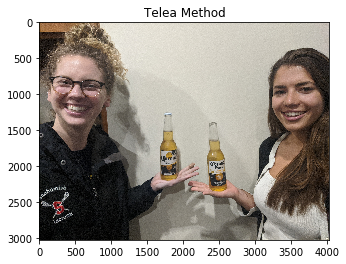

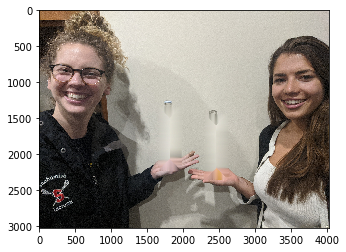

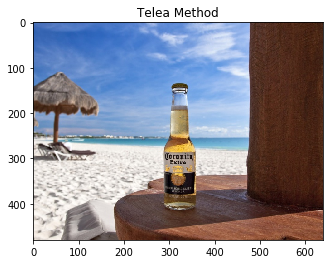

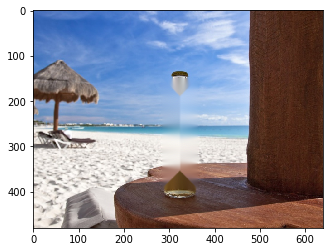

In [85]:
for (dst,img) in at_method:
    plt.imshow(img)
    plt.title("Telea Method")
    plt.show()
    plt.imshow(dst)
    plt.show()

The Telea method seems to produce more aesthetic results. 